In [1]:
from submission import *

dataset = 20

# this is the encoder data
with np.load("../data/Encoders%d.npz"%dataset) as data:
    encoder_counts = data["counts"] # 4 x n encoder counts [FR, FL, RR, RL
    encoder_stamps = data["time_stamps"] # encoder time stamps

# this is the lidar data
with np.load("../data/Hokuyo%d.npz"%dataset) as data:
    lidar_angle_min = data["angle_min"] # start angle of the scan [rad]
    lidar_angle_max = data["angle_max"] # end angle of the scan [rad]
    lidar_angle_increment = data["angle_increment"] # angular distance between measurements [rad]
    lidar_range_min = data["range_min"] # minimum range value [m]
    lidar_range_max = data["range_max"] # maximum range value [m]
    lidar_ranges = data["ranges"]       # range data [m] (Note: values < range_min or > range_max should be discarded)
    lidar_stamps = data["time_stamps"]  # acquisition times of the lidar scans

# this is the imu data only need yaw angle 
with np.load("../data/Imu%d.npz"%dataset) as data:
    imu_angular_velocity = data["angular_velocity"] # angular velocity in rad/sec
    imu_linear_acceleration = data["linear_acceleration"] # accelerations in gs (gravity acceleration scaling)
    imu_stamps = data["time_stamps"]  # acquisition times of the imu measurements

# this is the camera 
with np.load("../data/Kinect%d.npz"%dataset) as data:
    disp_stamps = data["disparity_time_stamps"] # acquisition times of the disparity images
    rgb_stamps = data["rgb_time_stamps"] # acquisition times of the rgb images

# Disaparity data
with open('../data/Disparity%d.p'%dataset, 'rb') as file:
    disparity = pickle.load(file)

# RGB data
with open('../data/RGB%d.p'%dataset, 'rb') as file:
    rgb = pickle.load(file)

# prind all the data shapes
print("encoder_counts", encoder_counts.shape)
print("encoder_stamps", encoder_stamps.shape)
print("lidar_ranges", lidar_ranges.shape)
print("lidar_stamsp", lidar_stamps.shape)

print("imu_angular_velocity", imu_angular_velocity.shape)
print("imu_linear_acceleration", imu_linear_acceleration.shape)
print("imu_stamps", imu_stamps.shape)

print("disparity", disparity.shape)
print("disp_stamps", disp_stamps.shape)
print("rgb_stamps", rgb_stamps.shape)
print("rgb", rgb.shape)


encoder_counts (4, 4956)
encoder_stamps (4956,)
lidar_ranges (1081, 4962)
lidar_stamsp (4962,)
imu_angular_velocity (3, 12187)
imu_linear_acceleration (3, 12187)
imu_stamps (12187,)
disparity (2407, 480, 640)
disp_stamps (2407,)
rgb_stamps (2289,)
rgb (2289, 480, 640, 3)


### Match Timestamps 

In [2]:
# encoder data
EncoderIMU_vt_wt = np.zeros((3, encoder_stamps.shape[0]))
j =-1
for i in range(encoder_stamps.shape[0]):
    while imu_stamps[j+1] < encoder_stamps[i] and j+1< imu_stamps.shape[0]-1:
        j += 1
    if i!=0:
        ts = encoder_stamps[i]-encoder_stamps[i-1]
        EncoderIMU_vt_wt[0, i] =0.0022*(((encoder_counts[0, i]+encoder_counts[1, i])/2) +(encoder_counts[2, i]+encoder_counts[3, i])/2)/(2*ts)
        EncoderIMU_vt_wt[1, i] = imu_angular_velocity[2, j]
        EncoderIMU_vt_wt[2, i] = ts
    else:
        EncoderIMU_vt_wt[0, i] = 0
        EncoderIMU_vt_wt[1, i] = 0
        EncoderIMU_vt_wt[2, i] = 0

        
# lidar data
lidar_new_ranges  = np.zeros((lidar_ranges.shape[0], encoder_counts.shape[1]))
j =-1
for i in range(encoder_stamps.shape[0]):
    while lidar_stamps[j+1] < encoder_stamps[i] and j+1< lidar_stamps.shape[0]-1:
        j += 1
    if i!=0:
        lidar_new_ranges[:, i] = lidar_ranges[:, j]
    else:
        lidar_new_ranges[:, i] = lidar_ranges[:, 0]


In [3]:
# match disparity and rgb
new_disparity = np.zeros((rgb.shape[0], rgb.shape[1],rgb.shape[2]))
j =-1
for i in range(rgb_stamps.shape[0]):
    while disp_stamps[j+1] < rgb_stamps[i] and j+1< disp_stamps.shape[0]-1:
        j += 1
    new_disparity[i] = disparity[j]

In [4]:
# match encoder to rgb
has_rgbimage = []
j =-1
l = -10
for i in range(rgb_stamps.shape[0]):
    while encoder_stamps[j+1] < rgb_stamps[i] and j+1< encoder_stamps.shape[0]-1:
        j += 1
    
    if l!=j:
        has_rgbimage.append(j)
    l = j


### Find xt+1

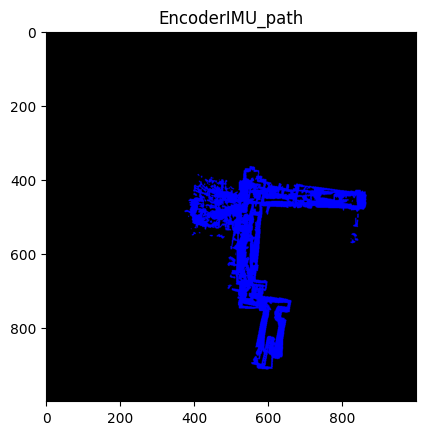

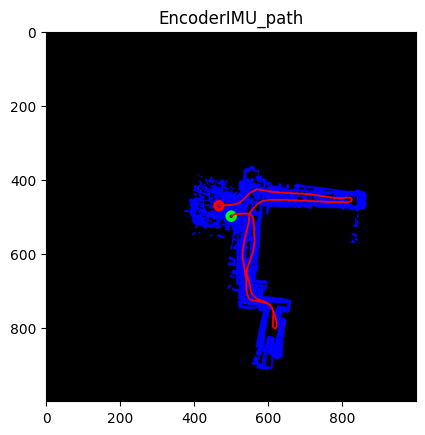

In [6]:
T_tx, wt = x_t_new(EncoderIMU_vt_wt)
plot_path(X_T=T_tx,xt_Lidar=True,ranges=lidar_new_ranges, title ="EncoderIMU_path")

### Scan Match the lidar cordinates 

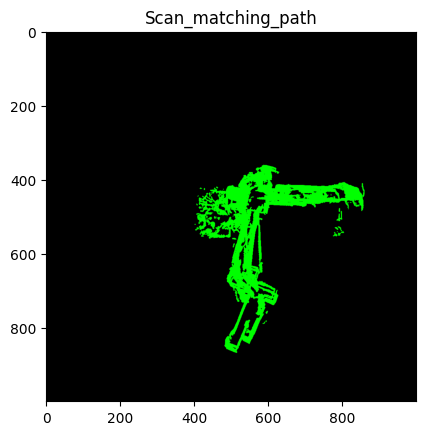

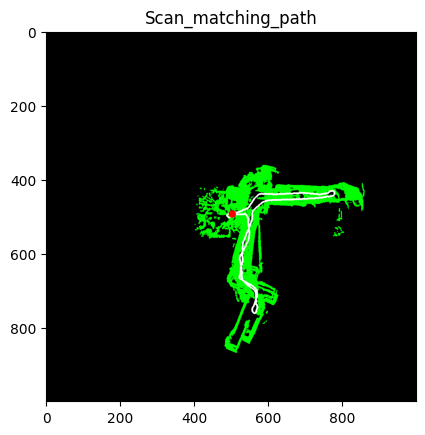

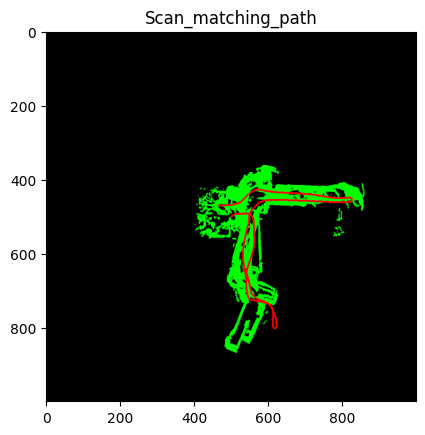

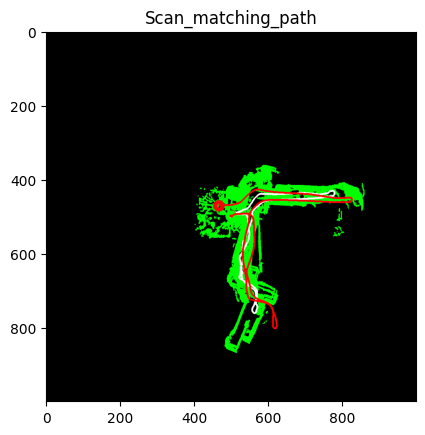

In [7]:
T_t, rel_T_t = scan_matching(T_tx,wt,lidar_new_ranges)
plot_path(T_t,T_tx,ipc_Lidar=True,ranges = lidar_new_ranges, title ="Scan_matching_path")

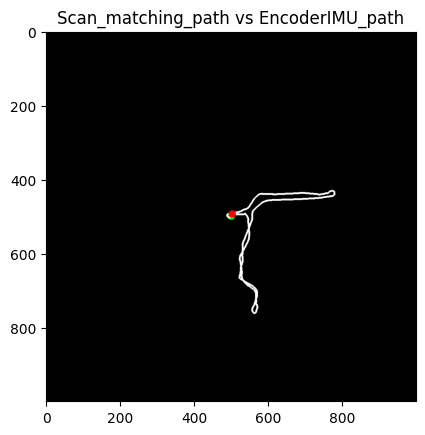

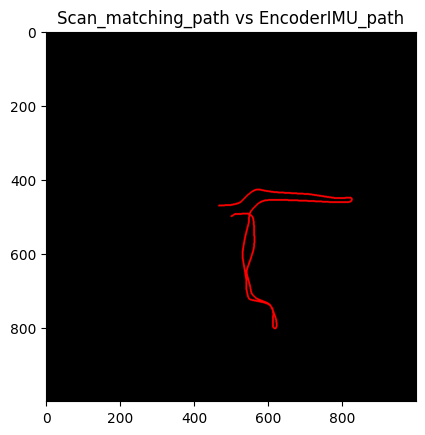

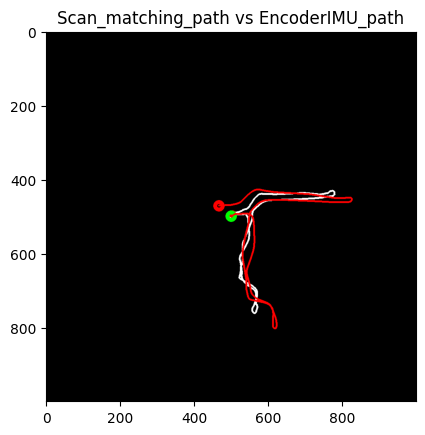

In [8]:
plot_path(T_t,T_tx, title ="Scan_matching_path vs EncoderIMU_path")

### Part 3 

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900


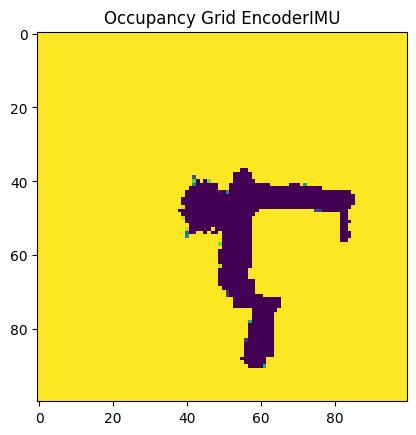

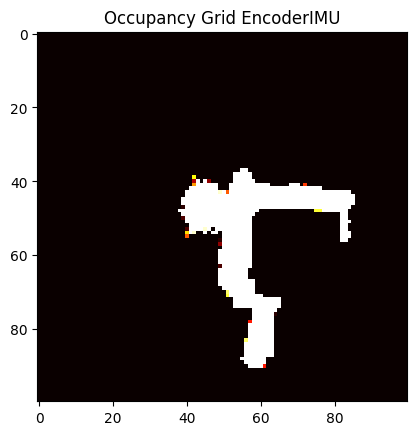

In [9]:
Occupancy_Grid(T_tx, lidar_new_ranges, title = "Occupancy Grid EncoderIMU")

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900


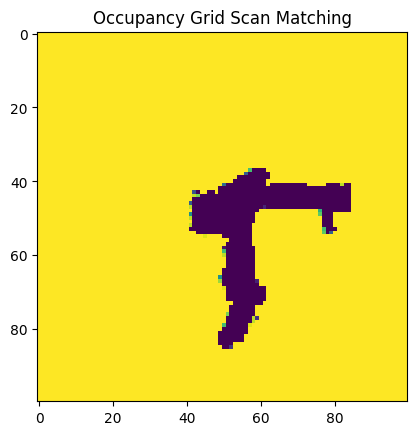

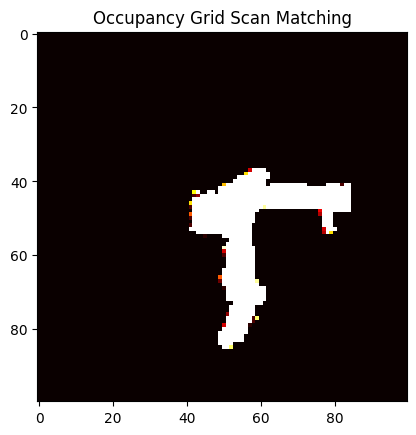

In [10]:
Occupancy_Grid(T_t, lidar_new_ranges, title = "Occupancy Grid Scan Matching")

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200


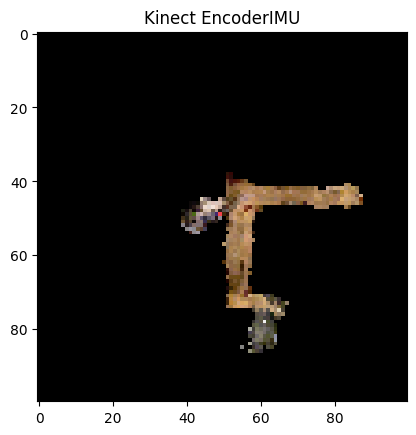

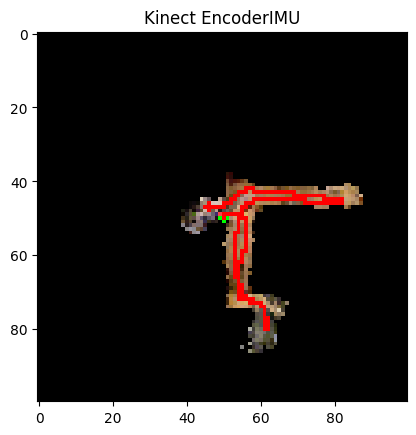

In [11]:
kinect(T_tx, has_rgbimage, new_disparity, rgb, title = "Kinect EncoderIMU")

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200


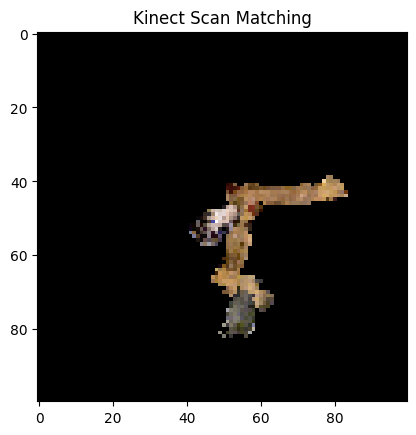

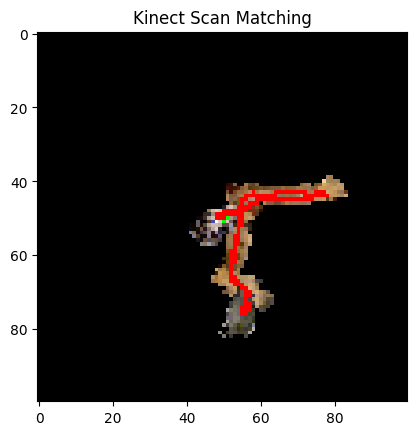

In [12]:
kinect(T_t, has_rgbimage,new_disparity,rgb, title = "Kinect Scan Matching")

### Part 4

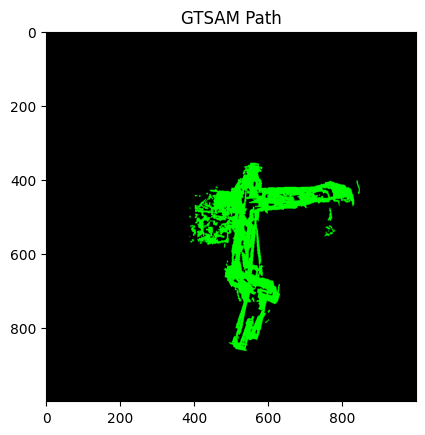

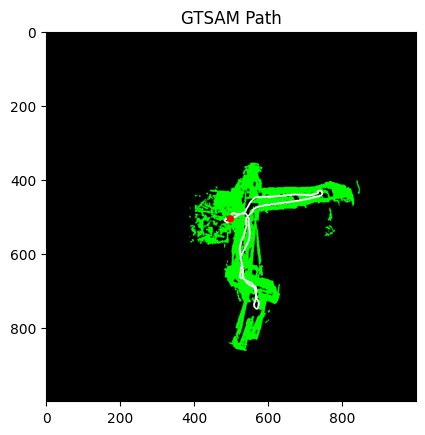

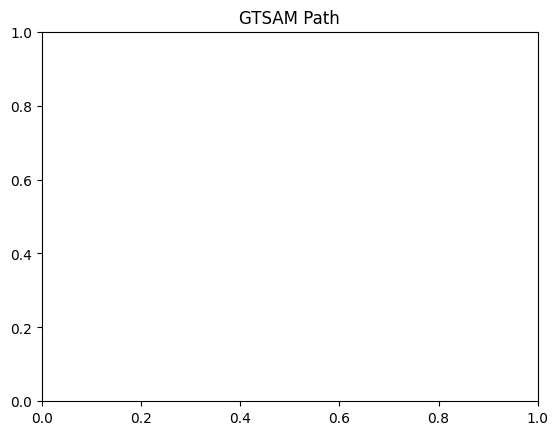

In [13]:

T_gtsam = gtsam_optimize(T_t, rel_T_t,T_tx,wt, lidar_new_ranges, plot = True)
plot_path(T_gtsam,ipc_Lidar=True,ranges = lidar_new_ranges,title="GTSAM Path")

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900


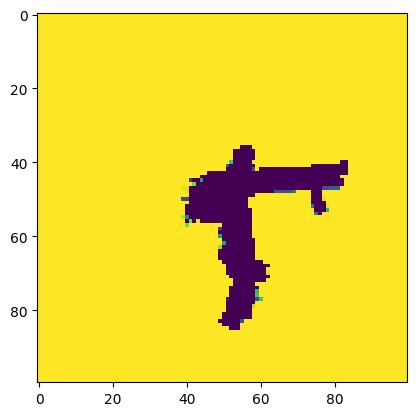

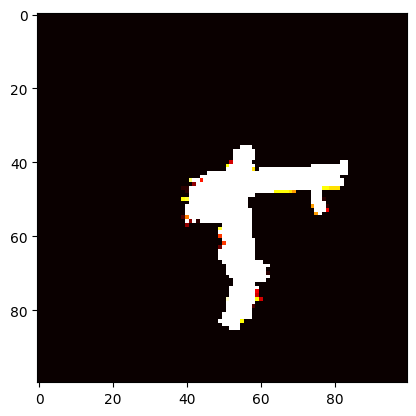

In [14]:
Occupancy_Grid(T_gtsam, lidar_new_ranges)

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200


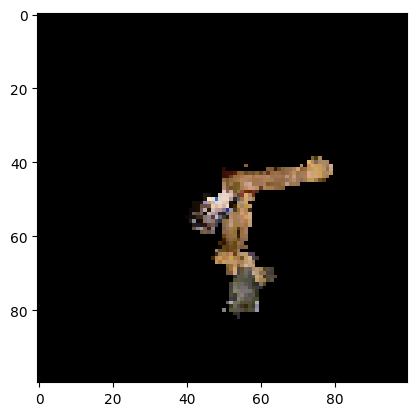

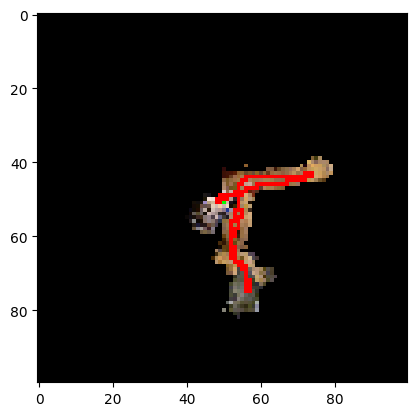

In [15]:
kinect(T_gtsam, has_rgbimage,new_disparity,rgb)
